# Putting all together in a pipeline


In [1]:
from ekorpkit import eKonf

if eKonf.is_colab():
    eKonf.mount_google_drive()
ws = eKonf.set_workspace(
    workspace="/workspace", 
    project="ekorpkit-book/exmaples", 
    task="esg", 
    log_level="INFO"
)
print("version:", ws.version)
print("project_dir:", ws.project_dir)

version: 0+unknown
project_dir: /workspace/projects/ekorpkit-book/exmaples
time: 1.01 s (started: 2022-12-29 10:48:36 +00:00)


## Preparing additional polarity data

In [2]:
from ekorpkit.datasets.dataset import Dataset

cfg = eKonf.compose("dataset=dataset")
cfg.name = 'esg_polarity_kr'
cfg.data_dir = cfg.path.data_dir
ds_pol = Dataset(**cfg)
data_files = ds_pol.data_files
data_files

INFO:ekorpkit.datasets.config:Loaded info file: /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_polarity_kr/info-esg_polarity_kr.yaml
INFO:ekorpkit.info.column:index: index, index of data: index, columns: ['id', 'text', 'labels', 'split'], id: ['id']
INFO:ekorpkit.info.column:Adding id [split] to ['id']
INFO:ekorpkit.info.column:Added id [split], now ['id', 'split']
INFO:ekorpkit.info.column:Added a column [split] with value [train]
INFO:ekorpkit.info.column:Added a column [split] with value [test]
INFO:ekorpkit.info.column:Added a column [split] with value [dev]


{'train': 'esg_polarity_kr-train.parquet',
 'test': 'esg_polarity_kr-test.parquet',
 'dev': 'esg_polarity_kr-dev.parquet'}

time: 2.18 s (started: 2022-12-17 00:31:28 +00:00)


In [3]:
pol_file = ws.project_dir / "esg/outputs/esg_polarity_labels/esg_polarity_labels(0)_export.parquet"
eKonf.copy(pol_file, ds_pol.data_dir)
pol_data = eKonf.load_data(pol_file)
# summary of labels column
pol_data["labels"].value_counts()

INFO:ekorpkit.ekonf:copied /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_labels/esg_polarity_labels(0)_export.parquet to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_polarity_kr


Neutral     622
Positive    437
Negative     99
Name: labels, dtype: int64

time: 18.7 ms (started: 2022-12-17 00:31:30 +00:00)


## Training further on the additional polarity data

In [4]:
from ekorpkit.models.transformer.simple import SimpleClassification

trained_model = "esg/models/esg_polarity-classification"

cfg = eKonf.compose('task=simple.classification')
cfg.name = "esg_polarity_further_train"
cfg.dataset.data_dir = ds_pol.data_dir
cfg.dataset.data_files = pol_file
cfg.dataset.test_size = 0.2
cfg.dataset.shuffle = True
cfg.dataset.seed = 1329829118
cfg.model.model_name_or_path = f"{ws.project_dir}/{trained_model}"
# cfg.model.model_name_or_path = "entelecheia/ekonelectra-base-discriminator"
cfg.trainer.num_train_epochs = 10
cfg.trainer.max_seq_length = 256
cfg.trainer.train_batch_size = 128
cfg.trainer.eval_batch_size = 128

sm = SimpleClassification(**cfg)

2022-12-17 00:31:31.138429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


time: 6.7 s (started: 2022-12-17 00:31:30 +00:00)


INFO:ekorpkit.datasets.config:Splitting the dataframe into train and test with ratio 0.2
INFO:ekorpkit.datasets.config:Shuffling the dataframe with seed 1329829118
INFO:ekorpkit.datasets.config:Train data: (926, 6)
INFO:ekorpkit.datasets.config:Test data: (232, 6)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_train_electra_256_3_2


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:   Starting fine-tuning.
INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_polarity_further_train-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2


Running Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.6891573875395348, 'acc': 0.8189655172413793, 'eval_loss': 0.4694342464208603}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_further_train/configs/esg_polarity_further_train(17)_config.yaml
INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_polarity_further_train-classification/best_model
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 2.34112883 -0.67941064 -1.39255905]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_further_train/esg_polarity_further_train(17)_preds.parquet


Accuracy:  0.8448275862068966
Precison:  0.8644108938029865
Recall:  0.8448275862068966
F1 Score:  0.8501989907520767
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    Negative       0.54      0.83      0.65        18
     Neutral       0.84      0.86      0.85       113
    Positive       0.95      0.83      0.89       101

    accuracy                           0.84       232
   macro avg       0.78      0.84      0.80       232
weighted avg       0.86      0.84      0.85       232



INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_further_train/esg_polarity_further_train(17)_confusion_matrix.png


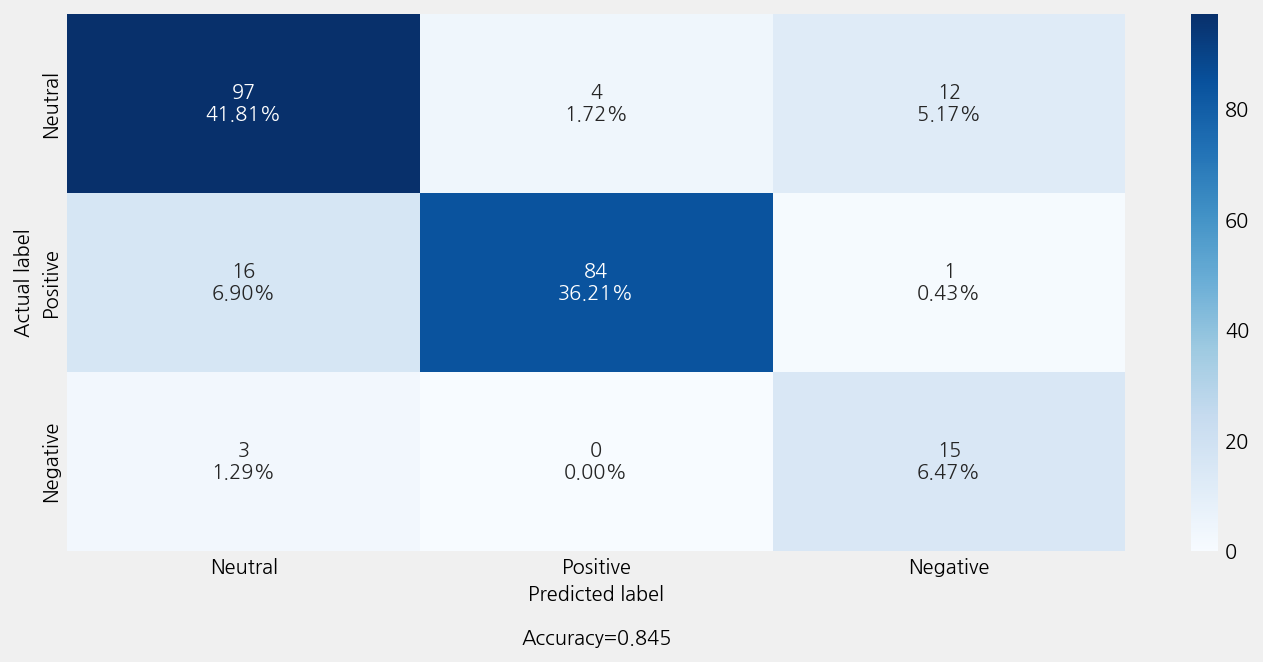

time: 2min 3s (started: 2022-12-17 00:31:37 +00:00)


In [5]:
sm.train()
sm.eval()

In [6]:
pol_preds = sm.predict(ds_pol.data)
print(pol_preds.shape)
cols = ["text", "labels", "pred_labels", "pred_probs"]
pol_preds[cols].head()

INFO:ekorpkit.io.file:Concatenating 3 dataframes
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/426 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 0.91535497 -1.61450195  0.57786864]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_further_train/esg_polarity_further_train(17)_preds.parquet


(13616, 7)


,text,labels,pred_labels,pred_probs
0,헌법재판소는 먼저 고발권 행사의 재량성에 대해서는 공정거래법은 제71조에서 '......,Negative,Neutral,0.557652
1,"특히, 그룹내 업종도 다르고 재무구조도 다른 계열사들이 그룹으로 묶여지는 특수한 지...",Neutral,Neutral,0.928248
2,"2018년 신규 취업자수는 36만명 증가하고, 전체 취업자 증가율은 1.4%로 20...",Neutral,Neutral,0.925551
3,앞서 분석한 대로 5월엔 펀더멘털 개선과 위험 요인들이 h지수의 방향을 좌우할 것이...,Neutral,Neutral,0.896470
4,재생에너지의 성장 속도는 향후 10년 안에 세계 주요 지역의 전통 에너지원 (con...,Positive,Positive,0.942311


time: 49.9 s (started: 2022-12-17 00:33:40 +00:00)


In [7]:
records_with_label_error = sm.find_label_errors(pol_preds)
print(len(records_with_label_error))
records_with_label_error[0]

INFO:ekorpkit.models.transformer.simple:Created 13616 records


3124


TextClassificationRecord(text='재생에너지는 태양 열, 태양광, 풍력, 수력(2003년 이후 10mw 이상의 대규모 수력발전 포함, 펌프 저장 수력 은 제외), 조력, 지열, 바이오, 폐기물로 구성되며, 바이오는 바이오가스, lfg(landfill gas), 바이오디젤, 우드 칩 & 펠렛, 성형탄, 임산연료, 폐목재, 흑액, 하수슬러지 고형연 료, 바이오 srf(solid refuse fuel), 바이오 중유로 구성되고, 폐기물은 폐가스, 산업폐기물, 생활폐기물, 대형 도시 쓰레기, 시멘트 킬린 보조 연료, rdf(refuse-derived fuel), rpf(refuse plastic fuel), tdf(tire-derived fuel), srf, 정제 연료유, 폐목재로 구성되며, 신에너지는 연료전지와 igcc(integrated gasification combined cycle)을 포함한 다(에너지경제연구원, 2017)', inputs={'text': '재생에너지는 태양 열, 태양광, 풍력, 수력(2003년 이후 10mw 이상의 대규모 수력발전 포함, 펌프 저장 수력 은 제외), 조력, 지열, 바이오, 폐기물로 구성되며, 바이오는 바이오가스, lfg(landfill gas), 바이오디젤, 우드 칩 & 펠렛, 성형탄, 임산연료, 폐목재, 흑액, 하수슬러지 고형연 료, 바이오 srf(solid refuse fuel), 바이오 중유로 구성되고, 폐기물은 폐가스, 산업폐기물, 생활폐기물, 대형 도시 쓰레기, 시멘트 킬린 보조 연료, rdf(refuse-derived fuel), rpf(refuse plastic fuel), tdf(tire-derived fuel), srf, 정제 연료유, 폐목재로 구성되며, 신에너지는 연료전지와 igcc(integrated gasification combined cycle)을 포함한 다(에너지경제연구원, 2017)'}, prediction=[('Neutral', 0.029362538787583405), ('

time: 5.63 s (started: 2022-12-17 00:34:30 +00:00)


In [8]:
# remove rows from preds that have label errors
pol_preds_new = pol_preds.copy()
for record in records_with_label_error:
    metadata = record.metadata
    pol_preds_new = pol_preds_new[pol_preds_new.id != metadata["id"]]
print(len(pol_preds_new))
filename = "esg_polarity_data_validated.parquet"
eKonf.save_data(pol_preds_new, filename, ds_pol.data_dir)

INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_polarity_kr/esg_polarity_data_validated.parquet


10492
time: 3.61 s (started: 2022-12-17 00:34:36 +00:00)


In [9]:
data_pol_merged = eKonf.concat_data([pol_preds_new[['text', 'labels']], pol_data[['text', 'labels']]], axis=0)
print(data_pol_merged.shape)
print(data_pol_merged.labels.value_counts())
# Save data
valid_pol_file = "esg_polarity_labels_validated.parquet"
valid_data_dir = ws.project_dir / "esg/data/esg_polarity_validated"
eKonf.save_data(data_pol_merged, valid_pol_file, valid_data_dir)

INFO:ekorpkit.io.file:Concatenating 2 dataframes
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_polarity_validated/esg_polarity_labels_validated.parquet


(11650, 2)
Neutral     8744
Positive    2138
Negative     768
Name: labels, dtype: int64
time: 692 ms (started: 2022-12-17 00:34:39 +00:00)


In [10]:
from ekorpkit.models.transformer.simple import SimpleClassification

trained_model = "esg/models/esg_polarity-classification"
valid_pol_file = "esg_polarity_labels_validated.parquet"
valid_data_dir = ws.project_dir / "esg/data/esg_polarity_validated"

cfg = eKonf.compose('task=simple.classification')
cfg.name = "esg_polarity_validated"
cfg.dataset.data_dir = valid_data_dir
cfg.dataset.data_files = valid_pol_file
cfg.dataset.test_size = 0.2
cfg.dataset.dev_size = 0.2
cfg.dataset.shuffle = True
cfg.dataset.seed = 1329829118
cfg.model.model_name_or_path = f"{ws.project_dir}/{trained_model}"
cfg.trainer.num_train_epochs = 10
cfg.trainer.max_seq_length = 256
cfg.trainer.train_batch_size = 128
cfg.trainer.eval_batch_size = 128

sm = SimpleClassification(**cfg)

time: 2.5 s (started: 2022-12-17 00:34:40 +00:00)


INFO:ekorpkit.datasets.config:Splitting the dataframe into train and test with ratio 0.2
INFO:ekorpkit.datasets.config:Splitting the dataframe into train and dev with ratio 0.2
INFO:ekorpkit.datasets.config:Shuffling the dataframe with seed 1329829118
INFO:ekorpkit.datasets.config:Train data: (7456, 2)
INFO:ekorpkit.datasets.config:Test data: (2330, 2)
INFO:ekorpkit.datasets.config:Dev data: (1864, 2)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_train_electra_256_3_2


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:   Starting fine-tuning.
INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8069432996637999, 'acc': 0.9125536480686696, 'eval_loss': 0.25196620722611746}


Running Epoch 1 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8419274870938194, 'acc': 0.9350858369098712, 'eval_loss': 0.17219401597976686}


Running Epoch 2 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8616681988721946, 'acc': 0.9431330472103004, 'eval_loss': 0.17937145059307416}


Running Epoch 3 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8164735813464941, 'acc': 0.9179184549356223, 'eval_loss': 0.28928871850172677}


Running Epoch 4 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8320324459516233, 'acc': 0.924892703862661, 'eval_loss': 0.2821295350790024}


Running Epoch 5 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8287765741836166, 'acc': 0.9243562231759657, 'eval_loss': 0.3702389821410179}


Running Epoch 6 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8184320449091033, 'acc': 0.9206008583690987, 'eval_loss': 0.37210700412591297}


Running Epoch 7 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.823652825682142, 'acc': 0.9206008583690987, 'eval_loss': 0.3642778545618057}


Running Epoch 8 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.848417005052376, 'acc': 0.9356223175965666, 'eval_loss': 0.30577353313565253}


Running Epoch 9 of 10:   0%|          | 0/59 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8422222079477867, 'acc': 0.9318669527896996, 'eval_loss': 0.3222779060403506}
INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_polarity_validated-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_3_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.8446079311622469, 'acc': 0.9356223175965666, 'eval_loss': 0.306164560349364}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_validated/configs/esg_polarity_validated(4)_config.yaml
INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_polarity_validated-classification/best_model
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 4.11547422 -1.68294871 -2.02361226]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_validated/esg_polarity_validated(4)_preds.parquet


Accuracy:  0.9343347639484979
Precison:  0.9377720839698163
Recall:  0.9343347639484979
F1 Score:  0.9350573882693292
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    Negative       0.73      0.94      0.82       142
     Neutral       0.96      0.95      0.96      1760
    Positive       0.91      0.85      0.88       428

    accuracy                           0.93      2330
   macro avg       0.87      0.92      0.89      2330
weighted avg       0.94      0.93      0.94      2330



INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_validated/esg_polarity_validated(4)_confusion_matrix.png


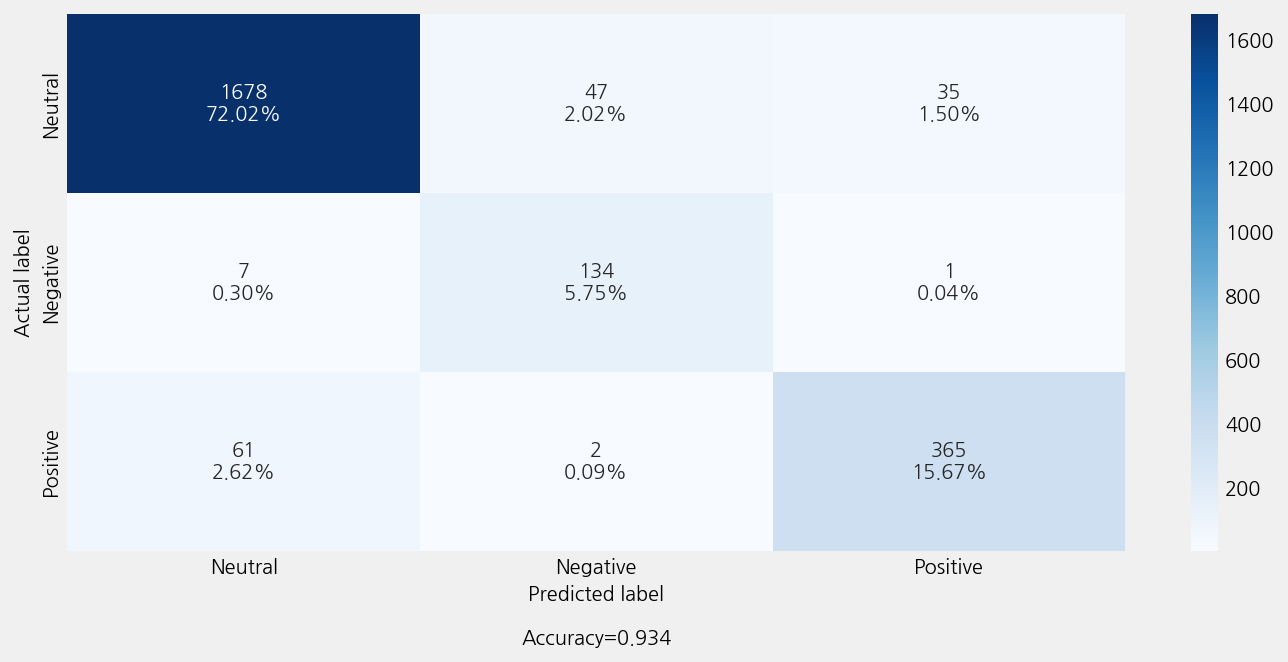

time: 13min 42s (started: 2022-12-17 00:34:42 +00:00)


In [11]:
sm.train()
sm.eval()

## Preparing invalid topic data

In [12]:
from ekorpkit.datasets.dataset import Dataset

cfg = eKonf.compose("dataset=dataset")
cfg.name = "esg_invalid_kr"
cfg.data_dir = cfg.path.data_dir
ds_inval = Dataset(**cfg)
print(ds_inval.data["labels"].value_counts())

INFO:ekorpkit.datasets.config:Loaded info file: /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_invalid_kr/info-esg_invalid_kr.yaml
INFO:ekorpkit.info.column:index: index, index of data: None, columns: ['text', 'labels', 'annotation'], id: ['id']
INFO:ekorpkit.info.column:Adding id [split] to ['id']
INFO:ekorpkit.info.column:Added id [split], now ['id', 'split']
INFO:ekorpkit.info.column:Added a column [split] with value [train]
INFO:ekorpkit.info.column:Added a column [split] with value [dev]
INFO:ekorpkit.info.column:Added a column [split] with value [test]
INFO:ekorpkit.io.file:Concatenating 3 dataframes


Validated    198
Discarded    173
Name: labels, dtype: int64
time: 1.39 s (started: 2022-12-17 00:48:25 +00:00)


In [13]:
file = ws.project_dir / "esg/outputs/esg_topic_labels/esg_topic_labels(0)_export.parquet"
tp_add = eKonf.load_data(file)
# summary of labels column
print(tp_add["labels"].value_counts())
# change value of labels column
# UNKNOWN -> Discarded
# Other values -> Validated
tp_add["labels"] = tp_add["labels"].apply(lambda x: "Discarded" if x == "UNKNOWN" else "Validated")
print(tp_add["labels"].value_counts())

UNKNOWN             212
E-환경혁신               72
G-지배구조               66
G-기업윤리/불공정/소송        57
E-기후변화               53
S-기업(공급망)동반성장/상생     33
ESG                  24
S-고용                 20
S-소비자                14
S-사회공헌               11
S-재해/안전관리             9
E-환경영향                5
Name: labels, dtype: int64
Validated    364
Discarded    212
Name: labels, dtype: int64
time: 11.7 ms (started: 2022-12-17 00:48:27 +00:00)


In [14]:
# combine two datasets
data_inval = eKonf.concat_data([ds_inval.data, tp_add], axis=0)
print(data_inval.labels.value_counts())
data_inval.head()
# Save data
file_inval = "esg_invalid_kr_merged.parquet"
eKonf.save_data(data_inval, file_inval, ds_inval.data_dir)

INFO:ekorpkit.io.file:Concatenating 3 dataframes
INFO:ekorpkit.io.file:Concatenating 2 dataframes
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_invalid_kr/esg_invalid_kr_merged.parquet


Validated    562
Discarded    385
Name: labels, dtype: int64
time: 114 ms (started: 2022-12-17 00:48:27 +00:00)


## Training an invalid topic classifier

In [15]:
from ekorpkit.models.transformer.simple import SimpleClassification


cfg = eKonf.compose('task=simple.classification')
cfg.name = "esg_topic_invalid_merged"
cfg.dataset.data_dir = ds_inval.data_dir
cfg.dataset.data_files = file_inval
cfg.dataset.test_size = 0.2
# cfg.dataset.dev_size = 0.2
cfg.dataset.seed = 3247616750
cfg.dataset.shuffle = True
cfg.model.model_name_or_path = "entelecheia/ekonelectra-base-discriminator"
cfg.trainer.num_train_epochs = 10
cfg.trainer.max_seq_length = 256
cfg.trainer.train_batch_size = 128
cfg.trainer.eval_batch_size = 128

sm_inval = SimpleClassification(**cfg)

time: 3.43 s (started: 2022-12-17 00:48:27 +00:00)


In [16]:
cv_preds_inval = sm_inval.cross_val_predict(cv=3, dev_size=0)

INFO:ekorpkit.datasets.config:Splitting the dataframe into train and test with ratio 0.2
INFO:ekorpkit.datasets.config:Shuffling the dataframe with seed 3247616750
INFO:ekorpkit.datasets.config:Train data: (757, 8)
INFO:ekorpkit.datasets.config:Test data: (190, 8)
INFO:ekorpkit.io.file:Concatenating 2 dataframes
INFO:ekorpkit.datasets.config:Train data: (631, 8)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model t

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topic_invalid_merged-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_2_2


Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5261215129920984, 'tp': 86, 'tn': 159, 'fp': 32, 'fn': 39, 'auroc': 0.8100314136125654, 'auprc': 0.7284616601212042, 'acc': 0.7753164556962026, 'eval_loss': 0.5155150691668192}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_merged/configs/esg_topic_invalid_merged(15)_config.yaml
INFO:ekorpkit.models.transformer.simple:Predicting split 0
INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topic_invalid_merged-classification/best_model
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 0.30730882 -0.42756858]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_merged/esg_topic_invalid_merged(15)_preds.parquet
INFO:ekorpkit.datasets.config:Train data: (631, 11)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoi

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topic_invalid_merged-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_2_2


Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.45064146873687305, 'tp': 151, 'tn': 80, 'fp': 59, 'fn': 26, 'auroc': 0.7718164451489655, 'auprc': 0.8065880177626839, 'acc': 0.7310126582278481, 'eval_loss': 0.6036376555760702}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_merged/configs/esg_topic_invalid_merged(16)_config.yaml
INFO:ekorpkit.models.transformer.simple:Predicting split 1
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 0.4058331  -0.54761481]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_merged/esg_topic_invalid_merged(16)_preds.parquet
INFO:ekorpkit.datasets.config:Train data: (632, 11)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoi

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topic_invalid_merged-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_2_2


Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5419871264455952, 'tp': 169, 'tn': 79, 'fp': 42, 'fn': 25, 'auroc': 0.8571824145863509, 'auprc': 0.8965878070149698, 'acc': 0.7873015873015873, 'eval_loss': 0.46483340859413147}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_merged/configs/esg_topic_invalid_merged(17)_config.yaml
INFO:ekorpkit.models.transformer.simple:Predicting split 2
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 0.02637419 -0.22079509]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_merged/esg_topic_invalid_merged(17)_preds.parquet
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_merged/esg_topic_invalid_merged(17)_cv.parquet


time: 6min (started: 2022-12-17 00:48:30 +00:00)


In [17]:
cols = ["text", "labels", "pred_labels", "raw_preds", "pred_probs"]
cv_preds_inval = cv_preds_inval[cols].reset_index()

time: 2.8 ms (started: 2022-12-17 00:54:31 +00:00)


In [18]:

inval_cv_filename = "esg_invalid_cv_preds.parquet"
eKonf.save_data(cv_preds_inval, inval_cv_filename, ds_inval.data_dir)

INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_invalid_kr/esg_invalid_cv_preds.parquet


time: 112 ms (started: 2022-12-17 00:54:31 +00:00)


In [19]:
inval_cv_filename = "esg_invalid_cv_preds.parquet"
cv_preds_inval = eKonf.load_data(inval_cv_filename, ds_inval.data_dir)

time: 16.5 ms (started: 2022-12-17 00:54:31 +00:00)


In [20]:
records_with_label_error = sm_inval.find_label_errors(cv_preds_inval, meta_columns=["index"])
print(len(records_with_label_error))
print(records_with_label_error[0])

# remove rows from preds that have label errors
data_inval_cved = cv_preds_inval.copy()
for record in records_with_label_error:
    metadata = record.metadata
    data_inval_cved = data_inval_cved[data_inval_cved.index != metadata["index"]]
print(len(data_inval_cved))
inval_cved_filename = "esg_invalid_data_cved.parquet"
eKonf.save_data(data_inval_cved, inval_cved_filename, ds_inval.data_dir)

INFO:ekorpkit.models.transformer.simple:Created 947 records
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_invalid_kr/esg_invalid_data_cved.parquet


113
text=' LG화학이 서울대와 손잡고 인공지능(AI)과 빅데이터를 통한 디지털 전환(DX·Digital Transformation)에 속도를 낸다  29일 LG화학은 서울대 공과대학에서 서울대와 \'LG화학-서울대 DX 산학협력센터\' 설립 협약식을 개최했다고 밝혔다  LG화학과 서울대는 DX 분야 산학협력을 통해 다양한 과제를 발굴해 수행하고 디지털 혁신을 선도할 인재를 양성하기 위해 협력해나간다는 계획이다  양측은 △DX 산학협력 과제 추진 △DX 핵심 인력 양성 교육 실시 △산학장학생 제도 운영 등 3개 분야에서 협력을 약속했다  DX 산학협력센터는 다음달부터 서울대 공과대학에서 운영된다  양측은 먼저 생산·품질·연구개발(R&D)·마케팅 등 주요 핵심 영역에서 딥러닝, 데이터 마이닝 등 디지털 기술을 적용할 수 있는 공동 핵심과제를 발굴하고 수행할 계획이다  이를 위해 다음 달까지 후보 과제를 발굴·선정해 약 1년에 걸쳐 수행하고 후속 과제도 발굴할 예정이다  LG화학 임직원들을 대상으로 DX 핵심 인력 양성 교육을 진행하고 서울대 석·박사 산학장학생 제도를 운영하는 등 디지털 분야 미래 인재 육성과 산업 경쟁력 강화에도 노력할 방침이다  김성민 LG화학 CHO는 "AI, 빅데이터 등 4차 산업혁명과 디지털 전환이라는 세계적인 흐름에 발맞추기 위해 핵심 기술 및 관련 제품을 스스로 개발할 수 있는 인재를 육성하는 등 DX 역량을 강화하겠다"고 말했다  LG화학은 올해 DX 전담조직을 신설하고 IT 시스템의 90% 이상 클라우드 전환, 업무 지원 로봇 및 소프트웨어 표준 도입 등을 수행하는 등 디지털 전환에 집중하고 있다  [최근도 기자] ' inputs={'text': ' LG화학이 서울대와 손잡고 인공지능(AI)과 빅데이터를 통한 디지털 전환(DX·Digital Transformation)에 속도를 낸다  29일 LG화학은 서울대 공과대학에서 서울대와 \'LG화학-서울대 DX 산학협력센터\' 설립 협약식을 개최했다고 밝혔다  LG화학과 서울대는

In [21]:
from ekorpkit.models.transformer.simple import SimpleClassification

inval_cved_filename = "esg_invalid_data_cved.parquet"

cfg = eKonf.compose('task=simple.classification')
cfg.name = "esg_topic_invalid_cved"
cfg.dataset.data_dir = ds_inval.data_dir
cfg.dataset.data_files = inval_cved_filename
cfg.dataset.test_size = 0.3
# cfg.dataset.dev_size = 0.2
cfg.dataset.seed = 3247616750
cfg.dataset.shuffle = True
cfg.model.model_name_or_path = "entelecheia/ekonelectra-base-discriminator"
cfg.trainer.num_train_epochs = 10
cfg.trainer.max_seq_length = 512
cfg.trainer.train_batch_size = 48
cfg.trainer.eval_batch_size = 48

sm_inval = SimpleClassification(**cfg)

time: 3.47 s (started: 2022-12-17 00:54:31 +00:00)


INFO:ekorpkit.datasets.config:Splitting the dataframe into train and test with ratio 0.3
INFO:ekorpkit.datasets.config:Shuffling the dataframe with seed 3247616750
INFO:ekorpkit.datasets.config:Train data: (583, 6)
INFO:ekorpkit.datasets.config:Test data: (251, 6)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificati

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/13 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topic_invalid_cved-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_512_2_2


Running Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5644373413818418, 'tp': 55, 'tn': 149, 'fp': 24, 'fn': 23, 'auroc': 0.892322513709797, 'auprc': 0.7437838409291504, 'acc': 0.8127490039840638, 'eval_loss': 0.6239469746748606}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_cved/configs/esg_topic_invalid_cved(1)_config.yaml
INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topic_invalid_cved-classification
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 2.2862947  -2.30610156]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_cved/esg_topic_invalid_cved(1)_preds.parquet


Accuracy:  0.8127490039840638
Precison:  0.8134265997534735
Recall:  0.8127490039840638
F1 Score:  0.8130739664806114
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

   Discarded       0.70      0.71      0.70        78
   Validated       0.87      0.86      0.86       173

    accuracy                           0.81       251
   macro avg       0.78      0.78      0.78       251
weighted avg       0.81      0.81      0.81       251



INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_cved/esg_topic_invalid_cved(1)_confusion_matrix.png


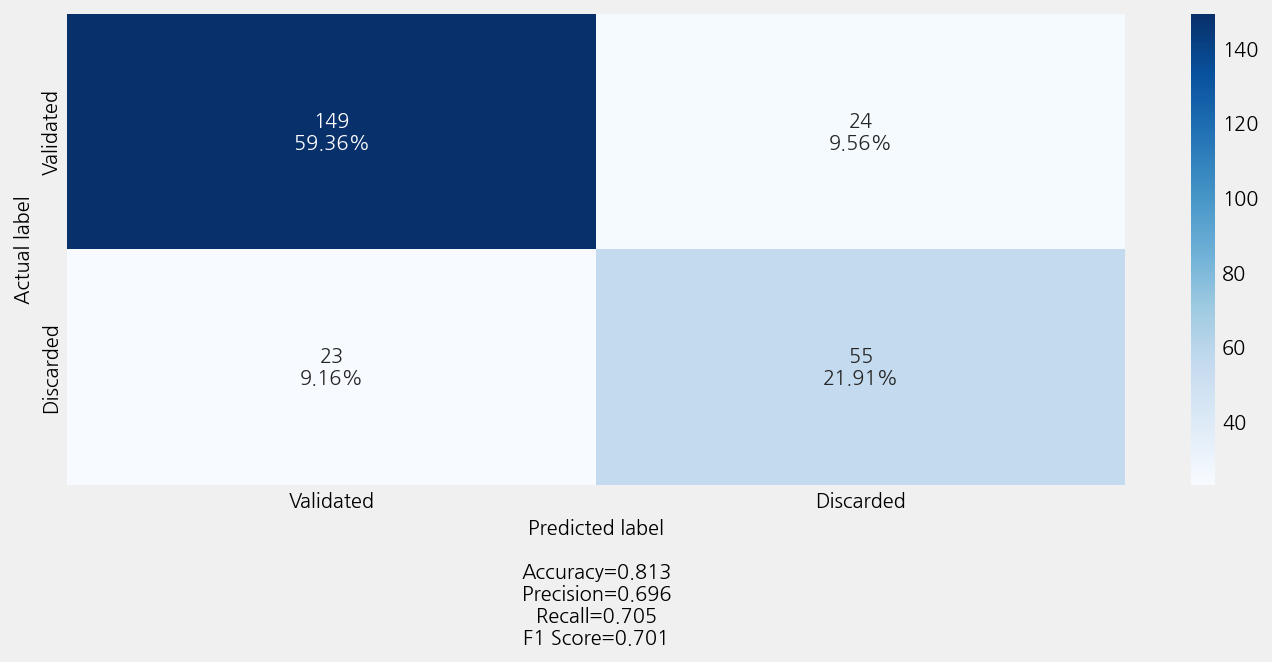

time: 2min 59s (started: 2022-12-17 00:54:35 +00:00)


In [22]:
sm_inval.train()
sm_inval.eval()

### Filter out invalid topics

In [23]:
cfg = eKonf.compose("dataset=dataset")
cfg.name = "esg_topics_improved"
cfg.data_dir = "/workspace/data/datasets/simple"
ds_tp = Dataset(**cfg)
labels = list(ds_tp.splits['train'].labels.unique())
print(labels, len(labels), ds_tp.num_rows)

INFO:ekorpkit.info.column:index: index, index of data: index, columns: ['id', 'text', 'labels', 'class', 'example_id', 'count', 'split'], id: ['id']
INFO:ekorpkit.info.column:Adding id [split] to ['id']
INFO:ekorpkit.info.column:Added id [split], now ['id', 'split']
INFO:ekorpkit.info.column:Added a column [split] with value [train]
INFO:ekorpkit.info.column:Added a column [split] with value [dev]
INFO:ekorpkit.info.column:Added a column [split] with value [test]
INFO:ekorpkit.io.file:Concatenating 3 dataframes
INFO:ekorpkit.io.file:Concatenating 3 dataframes


['S-기업(공급망)동반성장/상생', 'G-지배구조', 'G-기업윤리/불공정/소송', 'S-소비자', 'E-환경혁신', 'S-사회공헌', 'S-고용', 'E-환경영향', 'E-기후변화', 'S-재해/안전관리'] 10 11054
time: 1.43 s (started: 2022-12-17 00:57:34 +00:00)


In [24]:
ds_tp_predicted = sm_inval.predict(ds_tp.data)

INFO:ekorpkit.io.file:Concatenating 3 dataframes
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/231 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 2.32957101 -2.3210566 ]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_cved/esg_topic_invalid_cved(1)_preds.parquet


time: 1min 21s (started: 2022-12-17 00:57:36 +00:00)


In [25]:
# select only validated data with pred_probs > 0.6
print(ds_tp.data.shape)
ds_tp_valid = ds_tp_predicted[(ds_tp_predicted.pred_labels == "Validated") & (ds_tp_predicted.pred_probs > 0.6)]
print(ds_tp_valid.shape)
print(ds_tp_valid.labels.value_counts())

INFO:ekorpkit.io.file:Concatenating 3 dataframes


(11054, 7)
(9108, 10)
S-소비자               2299
G-지배구조              1453
S-고용                1420
G-기업윤리/불공정/소송        854
E-환경혁신               716
S-사회공헌               642
E-환경영향               525
E-기후변화               521
S-재해/안전관리            348
S-기업(공급망)동반성장/상생     330
Name: labels, dtype: int64
time: 10.1 ms (started: 2022-12-17 00:58:57 +00:00)


In [26]:
file = ws.project_dir / "esg/outputs/esg_topic_labels/esg_topic_labels(0)_export.parquet"
tp_add = eKonf.load_data(file)
# exclude UNKNOWN and ESG
tp_add = tp_add[~tp_add["labels"].isin(["UNKNOWN", "ESG"])]
# combine tp_add and ds_tp_valid with ['text', 'labels'] columns only
ds_tp_merged = eKonf.concat_data([ds_tp_valid[['text', 'labels']], tp_add[['text', 'labels']]], axis=0)
print(ds_tp_merged.shape)
print(ds_tp_merged.labels.value_counts())
# Save data
valid_topic_file = "esg_topic_labels_validated.parquet"
valid_data_dir = ws.project_dir / "esg/data/esg_topic_validated"
eKonf.save_data(ds_tp_merged, valid_topic_file, valid_data_dir)

INFO:ekorpkit.io.file:Concatenating 2 dataframes
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_topic_validated/esg_topic_labels_validated.parquet


(9448, 2)
S-소비자               2313
G-지배구조              1519
S-고용                1440
G-기업윤리/불공정/소송        911
E-환경혁신               788
S-사회공헌               653
E-기후변화               574
E-환경영향               530
S-기업(공급망)동반성장/상생     363
S-재해/안전관리            357
Name: labels, dtype: int64
time: 664 ms (started: 2022-12-17 00:58:57 +00:00)


## Training further on the additional topic data

In [27]:
from ekorpkit.models.transformer.simple import SimpleClassification

valid_topic_file = "esg_topic_labels_validated.parquet"
valid_data_dir = ws.project_dir / "esg/data/esg_topic_validated"

cfg = eKonf.compose('task=simple.classification')
cfg.name = "esg_topics_validated"
cfg.dataset.data_dir = valid_data_dir
cfg.dataset.data_files = valid_topic_file
cfg.dataset.test_size = 0.3
cfg.dataset.shuffle = True
cfg.dataset.seed = 977634889
cfg.model.model_name_or_path = "entelecheia/ekonelectra-base-discriminator"
cfg.trainer.num_train_epochs = 10
cfg.trainer.max_seq_length = 256
cfg.trainer.train_batch_size = 128
cfg.trainer.eval_batch_size = 128

smt = SimpleClassification(**cfg)

time: 3.45 s (started: 2022-12-17 00:58:57 +00:00)


In [28]:
cv_preds_topic = smt.cross_val_predict(cv=4, dev_size=0)

INFO:ekorpkit.datasets.config:Splitting the dataframe into train and test with ratio 0.3
INFO:ekorpkit.datasets.config:Shuffling the dataframe with seed 977634889
INFO:ekorpkit.datasets.config:Train data: (6613, 2)
INFO:ekorpkit.datasets.config:Test data: (2835, 2)
INFO:ekorpkit.io.file:Concatenating 2 dataframes
INFO:ekorpkit.datasets.config:Train data: (7086, 2)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_validated-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.7605312922484171, 'acc': 0.7938187976291279, 'eval_loss': 0.8000878221110294}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/configs/esg_topics_validated(12)_config.yaml
INFO:ekorpkit.models.transformer.simple:Predicting split 0
INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_validated-classification
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 5.9853487  -1.57939267 -1.13330126 -1.34939277 -0.3317107   0.01635014
 -0.13009873 -0.1246738  -1.16066349 -1.43532479]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/esg_topics_validated(12)_preds.parquet
INFO:ekorpkit.datasets.config:Train data: (7086, 5)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- Th

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_validated-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.7719688515253981, 'acc': 0.8039796782387807, 'eval_loss': 0.788326875159615}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/configs/esg_topics_validated(13)_config.yaml
INFO:ekorpkit.models.transformer.simple:Predicting split 1
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 6.01948023 -1.58157551 -1.27724278 -1.53617513 -0.22583501 -0.175418
 -0.07375064 -0.01960763 -1.1382457  -1.31032717]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/esg_topics_validated(13)_preds.parquet
INFO:ekorpkit.datasets.config:Train data: (7086, 5)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_validated-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.7611969832189905, 'acc': 0.7955122777307366, 'eval_loss': 0.791275397727364}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/configs/esg_topics_validated(14)_config.yaml
INFO:ekorpkit.models.transformer.simple:Predicting split 2
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [-0.44262895 -1.98779929  5.92393446  0.49648684 -1.43522871 -1.86107802
 -0.57101792 -0.96842241 -0.23700489 -0.78135854]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/esg_topics_validated(14)_preds.parquet
INFO:ekorpkit.datasets.config:Train data: (7086, 5)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:No columns or data to rename
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- Th

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/56 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_validated-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2


Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.756168943381817, 'acc': 0.790008467400508, 'eval_loss': 0.8251208694357621}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/configs/esg_topics_validated(15)_config.yaml
INFO:ekorpkit.models.transformer.simple:Predicting split 3
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 6.02145815 -1.79686356 -1.11947501 -1.68748939 -0.29376069 -0.35863328
 -0.17506261  0.07965102 -0.94695491 -1.12279844]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/esg_topics_validated(15)_preds.parquet
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_validated/esg_topics_validated(15)_cv.parquet


time: 48min 31s (started: 2022-12-17 00:59:01 +00:00)


In [29]:
cols = ["text", "labels", "pred_labels", "raw_preds", "pred_probs"]
cv_preds_topic = cv_preds_topic[cols].reset_index()

time: 3.68 ms (started: 2022-12-17 01:47:32 +00:00)


In [30]:
records_with_label_error = smt.find_label_errors(cv_preds_topic, meta_columns=["index"])
print(len(records_with_label_error))
print(records_with_label_error[0])

# remove rows from preds that have label errors
data_topic_cved = cv_preds_topic.copy()
for record in records_with_label_error:
    metadata = record.metadata
    data_topic_cved = data_topic_cved[data_topic_cved.index != metadata["index"]]
print(len(data_topic_cved))
topic_cved_filename = "esg_topic_data_cved.parquet"
eKonf.save_data(data_topic_cved, topic_cved_filename, valid_data_dir)

INFO:ekorpkit.models.transformer.simple:Created 9448 records


388
text="싱가포르 항공 은 이번 평가 에서 좌석 공간 과 편안함 고객서비스 가격 대비 만족 도 청결 도 체크인 · 탑승 기내식 기내 엔터테인먼트 ( 무선 인터넷 · tv · 영화 ) 등 항목 에서 고르게 최고점 을 받았다 .\n특히 이코노미 클래스 와 퍼스트 클래스 에서 최우수 평가 를 받았다 .\n고춘 퐁 ( goh choon phong ) 싱가포르 항공 ceo 는 ' 이번 수상 은 싱가포르 항공 을 통해 고객 들 이 느낀 높은 만족감 을 보여준다는 점 에서 더욱 뜻 깊고 영광 스러운 일 ' 이라고 말 했다 .\n이어 ' 우수 한 고객 서비스 와 지속적 인 기내 프로덕트 혁신 을 통해 얻은 결과 인 만큼 앞 으로도 고객 의 기대 를 뛰어넘는 최고 의 비행 경험 을 선사 하기 위해 끊임없이 노력 할 것 ' 이라고 덧붙였다 ." inputs={'text': "싱가포르 항공 은 이번 평가 에서 좌석 공간 과 편안함 고객서비스 가격 대비 만족 도 청결 도 체크인 · 탑승 기내식 기내 엔터테인먼트 ( 무선 인터넷 · tv · 영화 ) 등 항목 에서 고르게 최고점 을 받았다 .\n특히 이코노미 클래스 와 퍼스트 클래스 에서 최우수 평가 를 받았다 .\n고춘 퐁 ( goh choon phong ) 싱가포르 항공 ceo 는 ' 이번 수상 은 싱가포르 항공 을 통해 고객 들 이 느낀 높은 만족감 을 보여준다는 점 에서 더욱 뜻 깊고 영광 스러운 일 ' 이라고 말 했다 .\n이어 ' 우수 한 고객 서비스 와 지속적 인 기내 프로덕트 혁신 을 통해 얻은 결과 인 만큼 앞 으로도 고객 의 기대 를 뛰어넘는 최고 의 비행 경험 을 선사 하기 위해 끊임없이 노력 할 것 ' 이라고 덧붙였다 ."} prediction=[('S-소비자', 0.9897604143328605), ('E-기후변화', 0.00033954614695828753), ('S-고용', 0.0010764540560271147), ('G-지배구조', 0.0006275287427944966), ('E-환경영향', 

INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_topic_validated/esg_topic_data_cved.parquet


9060
time: 4.95 s (started: 2022-12-17 01:47:32 +00:00)


In [31]:
file = ws.project_dir / "esg/outputs/esg_topic_labels/esg_topic_labels(0)_export.parquet"
tp_add = eKonf.load_data(file)
# exclude UNKNOWN and ESG
tp_add = tp_add[~tp_add["labels"].isin(["UNKNOWN", "ESG"])]
# combine tp_add and ds_tp_valid with ['text', 'labels'] columns only
topic_cv_merged = eKonf.concat_data([data_topic_cved[['text', 'labels']], tp_add[['text', 'labels']]], axis=0)
print(topic_cv_merged.shape)
print(topic_cv_merged.labels.value_counts())
# Save data
topic_cved_filename = "esg_topic_data_cved_mreged.parquet"
eKonf.save_data(topic_cv_merged, topic_cved_filename, valid_data_dir)

INFO:ekorpkit.io.file:Concatenating 2 dataframes
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/esg_topic_validated/esg_topic_data_cved_mreged.parquet


(9400, 2)
S-소비자               2265
G-지배구조              1545
S-고용                1436
G-기업윤리/불공정/소송        903
E-환경혁신               802
S-사회공헌               649
E-기후변화               591
E-환경영향               489
S-기업(공급망)동반성장/상생     362
S-재해/안전관리            358
Name: labels, dtype: int64
time: 692 ms (started: 2022-12-17 01:47:37 +00:00)


In [32]:
from ekorpkit.models.transformer.simple import SimpleClassification

topic_cved_filename = "esg_topic_data_cved_mreged.parquet"
valid_data_dir = ws.project_dir / "esg/data/esg_topic_validated"

cfg = eKonf.compose('task=simple.classification')
cfg.name = "esg_topics_cved"
cfg.dataset.data_dir = valid_data_dir
cfg.dataset.data_files = topic_cved_filename
cfg.dataset.test_size = 0.2
cfg.dataset.dev_size = 0.2
cfg.dataset.shuffle = True
cfg.dataset.seed = 977634889
cfg.model.model_name_or_path = "entelecheia/ekonelectra-base-discriminator"
cfg.trainer.num_train_epochs = 10
cfg.trainer.max_seq_length = 256
cfg.trainer.train_batch_size = 128
cfg.trainer.eval_batch_size = 128

smt = SimpleClassification(**cfg)

time: 3.49 s (started: 2022-12-17 01:47:38 +00:00)


In [33]:
smt.train()

INFO:ekorpkit.datasets.config:Splitting the dataframe into train and test with ratio 0.2
INFO:ekorpkit.datasets.config:Splitting the dataframe into train and dev with ratio 0.2
INFO:ekorpkit.datasets.config:Shuffling the dataframe with seed 977634889
INFO:ekorpkit.datasets.config:Train data: (6016, 2)
INFO:ekorpkit.datasets.config:Test data: (1880, 2)
INFO:ekorpkit.datasets.config:Dev data: (1504, 2)
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
INFO:ekorpkit.models.transformer.simple:Renaming columns: {}
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification f

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4053047266418383, 'acc': 0.49601063829787234, 'eval_loss': 1.7612815499305725}


Running Epoch 1 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7182882569855017, 'acc': 0.757313829787234, 'eval_loss': 0.9193831036488215}


Running Epoch 2 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7748971935126667, 'acc': 0.8065159574468085, 'eval_loss': 0.7227616955836614}


Running Epoch 3 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7864067428867297, 'acc': 0.8164893617021277, 'eval_loss': 0.6524468412001928}


Running Epoch 4 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7842642795170566, 'acc': 0.8138297872340425, 'eval_loss': 0.6461221526066462}


Running Epoch 5 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7914698596081943, 'acc': 0.8204787234042553, 'eval_loss': 0.6538690974315008}


Running Epoch 6 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7985231311837293, 'acc': 0.8264627659574468, 'eval_loss': 0.6644373387098312}


Running Epoch 7 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7993943198120286, 'acc': 0.8271276595744681, 'eval_loss': 0.6578289543588957}


Running Epoch 8 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8018733551633995, 'acc': 0.8297872340425532, 'eval_loss': 0.6825426071882248}


Running Epoch 9 of 10:   0%|          | 0/47 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.7989868884916935, 'acc': 0.8271276595744681, 'eval_loss': 0.6802134936054548}
INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_cved-classification.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file /workspace/.cache/cached_dev_electra_256_10_2


Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.8065837863234686, 'acc': 0.8335106382978723, 'eval_loss': 0.6546976029872894}
INFO:ekorpkit.config:Saving config to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_cved/configs/esg_topics_cved(3)_config.yaml


time: 11min 16s (started: 2022-12-17 01:47:41 +00:00)


INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_cved-classification/best_model
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 0.64087743 -0.97763002 -0.67245495 -1.31193423 -1.34377241  0.05310853
 -0.33475915  3.93648148 -0.79432243  0.83153814]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_cved/esg_topics_cved(3)_preds.parquet


Accuracy:  0.824468085106383
Precison:  0.8307886859209715
Recall:  0.824468085106383
F1 Score:  0.8238006616461439
Model Report: 
___________________________________________________
                  precision    recall  f1-score   support

          E-기후변화       0.91      0.64      0.75       129
          E-환경영향       0.75      0.70      0.72       105
          E-환경혁신       0.64      0.88      0.74       169
   G-기업윤리/불공정/소송       0.76      0.65      0.70       151
          G-지배구조       0.88      0.90      0.89       295
            S-고용       0.87      0.89      0.88       278
S-기업(공급망)동반성장/상생       0.77      0.68      0.72        73
          S-사회공헌       0.86      0.86      0.86       140
           S-소비자       0.87      0.86      0.87       465
       S-재해/안전관리       0.81      0.84      0.82        75

        accuracy                           0.82      1880
       macro avg       0.81      0.79      0.80      1880
    weighted avg       0.83      0.82      0.82      1880



INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_cved/esg_topics_cved(3)_confusion_matrix.png


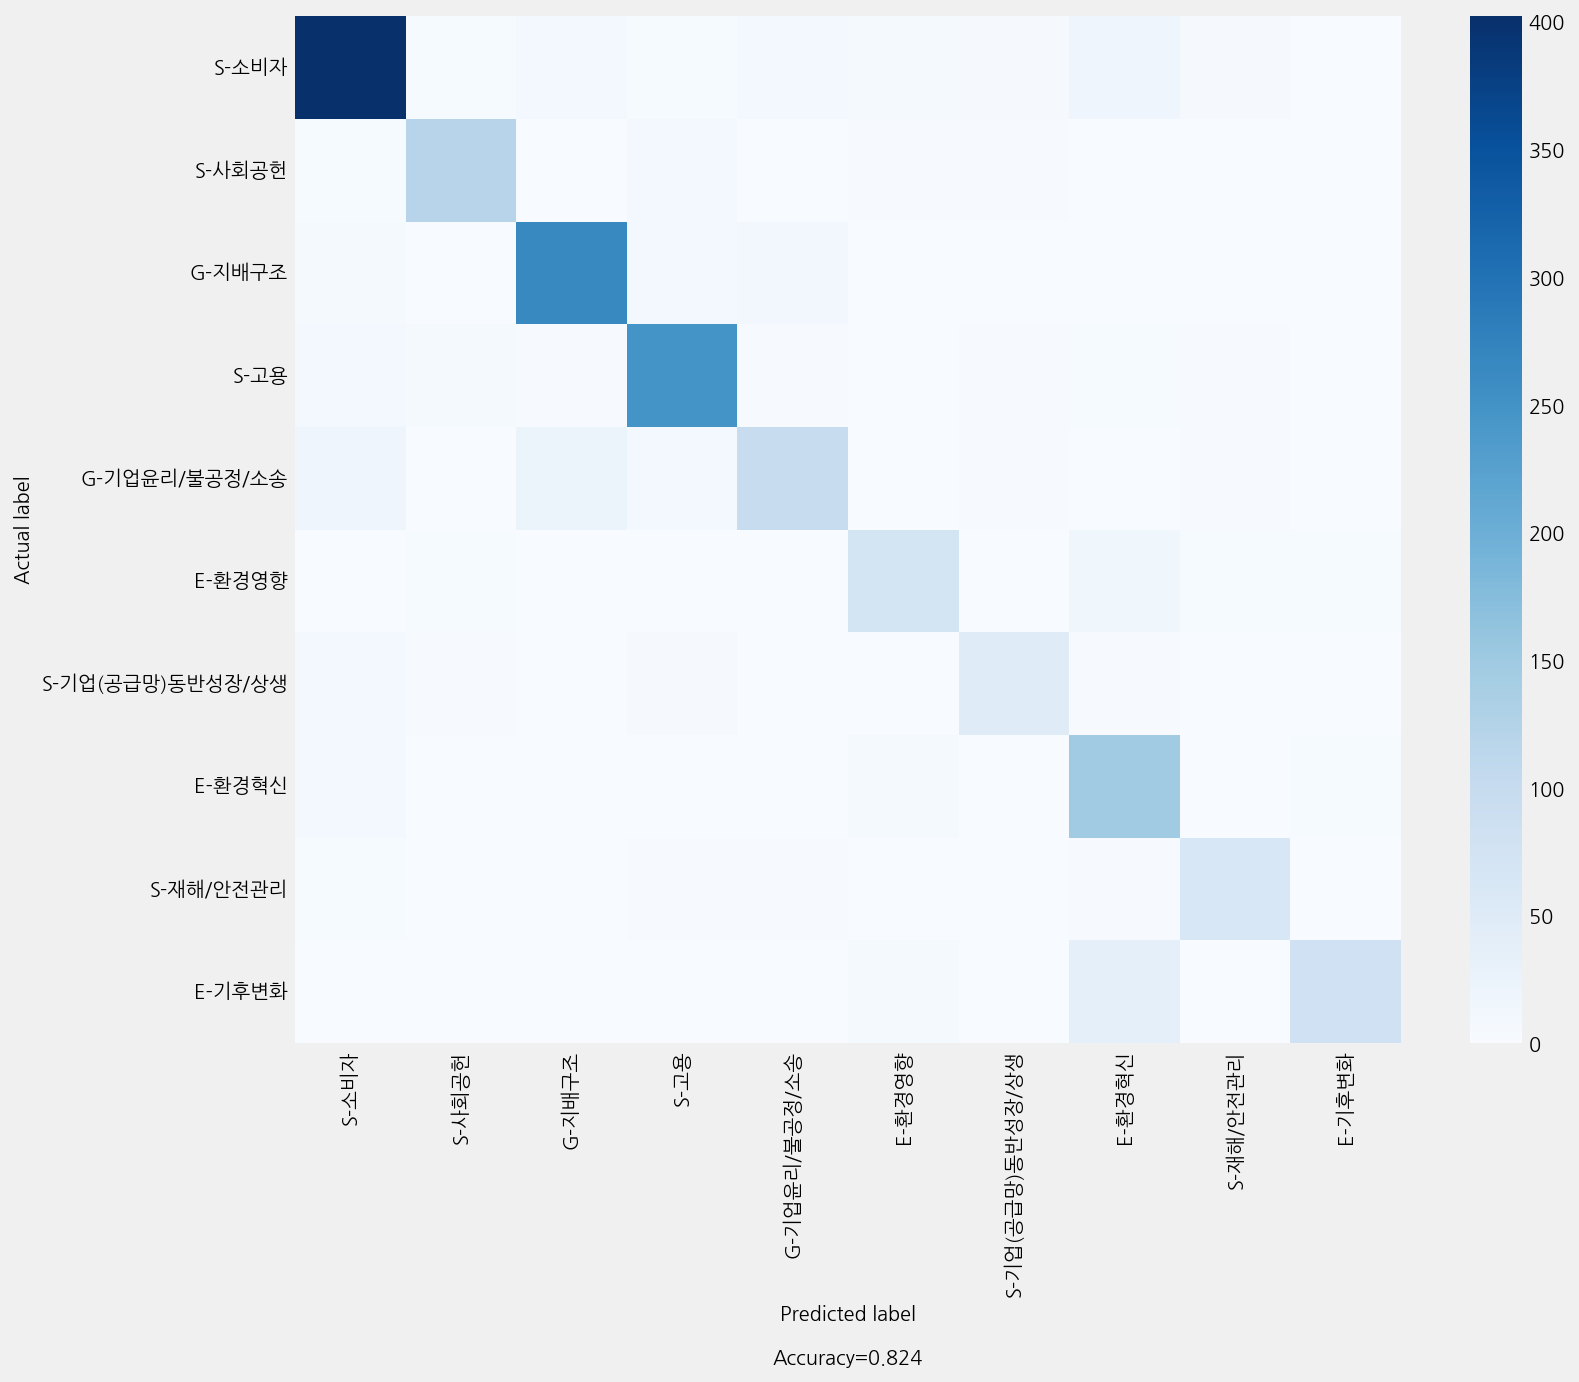

time: 9.86 s (started: 2022-12-17 01:58:58 +00:00)


In [34]:
smt.model.eval.visualize.plot.confusion_matrix.include_values = False
smt.model.eval.visualize.plot.confusion_matrix.include_percentages = False
smt.model.eval.visualize.plot.figure.figsize = (12,10)
smt.eval()

## Load data to predict

In [3]:
news_data_dir = ws.project_dir / "esg/data/econ_news_kr/news_slice"

chunk_data = eKonf.load_data(
    "econ_news_kr_chunks_*_20220911.parquet", news_data_dir, concatenate=True
)
print(chunk_data.shape)
chunk_data.head()

(1833910, 3)


,text,chunk_id,filename
0,△ 사진 설명 : 경자년 새해가 밝았다 제각각 삶터에서 묵묵히 노력하는 대한민국...,0,02100101.20200101001103001.txt
1,"""청년 벤처기업가들한테 진짜로 미안했어요 부끄럽고 "" 지난해 12월 29일 서울...",0,02100101.20200101001253001.txt
2,오늘부터 30년 후면 2050년이다 30년 전인 1990년을 전후하여 세계는 독...,0,02100101.20200101001855001.txt
3,◆ 2020 경제기상도 / 환율 ◆ 지난해 미·중 무역분쟁이라는 대형 변수로 출렁...,0,02100101.20200101040159002.txt
4,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆ 지난해 미·중 무역분쟁과 공...,0,02100101.20200101040200001.txt


time: 15.7 s (started: 2022-12-29 10:49:40 +00:00)


In [4]:
chunk_data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1833910 entries, 0 to 785336
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   text      object
 1   chunk_id  int64 
 2   filename  object
dtypes: int64(1), object(2)
memory usage: 56.0+ MB
time: 3.93 ms (started: 2022-12-29 10:49:56 +00:00)


## Load company code info


In [5]:
cfg = eKonf.compose("io/loader=plaintext_parser")
cfg.data_dir = news_data_dir
cfg.data_sources = "econ_news_kr_chunks_*_20221229.txt"
cfg.data.item = dict(filename="filename", codes="codes")
cfg.parser.split = True
cfg.parser.data_key = "codes"
cfg.parser.progress_per = None
code_info = eKonf.load_data(**cfg)
code_info.tail()

INFO:ekorpkit.io.load.data:==> processing 1/3 files <==
INFO:ekorpkit.io.parse.json:Number of data in the contents: 110689
INFO:ekorpkit.io.load.data:==> processing 2/3 files <==
INFO:ekorpkit.io.parse.json:Number of data in the contents: 281398
INFO:ekorpkit.io.load.data:==> processing 3/3 files <==
INFO:ekorpkit.io.parse.json:Number of data in the contents: 251404


{'filename': 'econ_news_kr_chunks_2022_code_20221229.txt', 'codes': '02100101.20220101002520005,1,005380'}


,filename,codes
643486,econ_news_kr_chunks_2020_code_20221229.txt,"02100851.20201231140203001,0,001680"
643487,econ_news_kr_chunks_2020_code_20221229.txt,"02100851.20201231141813001,0,001750"
643488,econ_news_kr_chunks_2020_code_20221229.txt,"02100851.20201231164457001,0,000660"
643489,econ_news_kr_chunks_2020_code_20221229.txt,"02100851.20201231171734001,0,006360"
643490,econ_news_kr_chunks_2020_code_20221229.txt,"02100851.20201231204324001,0,068270"


time: 1min (started: 2022-12-29 10:50:06 +00:00)


In [6]:
code_info_available = code_info.copy()
code_info_available["filename"] = code_info_available.codes.str[:26] + ".txt"
code_info_available["codes"] = code_info_available.codes.str[27:]
code_info_available["codes"] = code_info_available.codes.str.split(",")
code_info_available["chunk_id"] = code_info_available.codes.apply(lambda x: int(x[0]))
code_info_available["codes"] = code_info_available.codes.apply(lambda x: x[1:])
code_info_available["num_codes"] = code_info_available["codes"].apply(len)
code_info_available = code_info_available.explode("codes").reset_index(drop=True)


time: 2.63 s (started: 2022-12-29 10:51:16 +00:00)


In [7]:
len(code_info_available.codes.unique())

2275

time: 54.1 ms (started: 2022-12-29 10:51:20 +00:00)


In [8]:
code_info_available = code_info.copy()
code_info_available["filename"] = code_info_available.codes.str[:26] + ".txt"
code_info_available["codes"] = code_info_available.codes.str[27:]
code_info_available["codes"] = code_info_available.codes.str.split(",")
code_info_available["chunk_id"] = code_info_available.codes.apply(lambda x: int(x[0]))
code_info_available["codes"] = code_info_available.codes.apply(lambda x: x[1:])
code_info_available["num_codes"] = code_info_available["codes"].apply(len)
code_info_available = code_info_available.explode("codes").reset_index(drop=True)

eKonf.save_data(code_info_available, "econ_news_code_info_available_20221229.parquet", news_data_dir)
print(code_info_available.shape)
code_info_available.info()

INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/econ_news_kr/news_slice/econ_news_code_info_available_20221229.parquet


(694599, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694599 entries, 0 to 694598
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   filename   694599 non-null  object
 1   codes      694599 non-null  object
 2   chunk_id   694599 non-null  int64 
 3   num_codes  694599 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 21.2+ MB
time: 3.12 s (started: 2022-12-29 10:51:46 +00:00)


In [9]:
filtered_data = chunk_data.merge(
    code_info_available, on=["filename", "chunk_id"], how="inner"
)
cols = ["filename", "chunk_id", "text", "codes"]
filtered_data = filtered_data[cols]
eKonf.save_data(filtered_data, "econ_news_filtered_202201229.parquet", news_data_dir)
print(filtered_data.shape)

INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/econ_news_kr/news_slice/econ_news_filtered_202201229.parquet


(718453, 4)
time: 1min 7s (started: 2022-12-29 10:52:00 +00:00)


## Filter out invalid data

In [10]:
from ekorpkit.models.transformer.simple import SimpleClassification

cfg = eKonf.compose("task=simple.classification")
cfg.name = "esg_topic_invalid_cved"
cfg.model.model_name_or_path = f"{cfg.path.model_dir}/{cfg.name}-classification"

sm_inval = SimpleClassification(**cfg)
sm_inval.load_model(sm_inval.model.model_name_or_path)

2022-12-29 10:53:25.970902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topic_invalid_cved-classification


time: 7.21 s (started: 2022-12-29 10:53:25 +00:00)


In [11]:
invalid_preds_df = sm_inval.predict(filtered_data)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/14968 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 2.32296014 -2.33493686]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topic_invalid_cved/esg_topic_invalid_cved(2)_preds.parquet


time: 1h 30min 23s (started: 2022-12-29 10:53:38 +00:00)


In [12]:
cols = ["filename", "chunk_id", "text", "codes"]
valid_data = invalid_preds_df[invalid_preds_df.pred_labels == "Validated"][cols]
print(valid_data.shape)
filename = "esg_news_valid_20221229.parquet"
eKonf.save_data(valid_data, filename, news_data_dir)

INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/econ_news_kr/news_slice/esg_news_valid_20221229.parquet


(558923, 4)
time: 1min 3s (started: 2022-12-29 12:24:02 +00:00)


In [13]:
news_data_dir = ws.project_dir / "esg/data/econ_news_kr/news_slice"
filename = "esg_news_valid_20221229.parquet"

valid_data = eKonf.load_data(filename, news_data_dir)
cols = ["text", "filename", "chunk_id", "codes"]
valid_data[cols].head()

,text,filename,chunk_id,codes
0,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆ 지난해 미·중 무역분쟁과 공...,02100101.20200101040200001.txt,0,000660
2,"◆ 2020 경제기상도 / 업종별 전망 (가전) ◆ TV, 냉장고, 세탁기 등 전...",02100101.20200101040200002.txt,0,066570
3,"◆ 2020 경제기상도 / 업종별 전망 (가전) ◆ TV, 냉장고, 세탁기 등 전...",02100101.20200101040200002.txt,0,005930
4,◆ 2020 경제기상도 / 업종별 전망 (디스플레이) ◆ 액정표시장치(LCD) 시...,02100101.20200101040201001.txt,0,034220
5,디스플레이 업계 등에서는 삼성과 LG가 글로벌 디스플레이 시장에서 중국 업체의 L...,02100101.20200101040201001.txt,1,003550


time: 7 s (started: 2022-12-29 12:25:05 +00:00)


## Predict polarities

In [14]:
from ekorpkit.models.transformer.simple import SimpleClassification

cfg = eKonf.compose("task=simple.classification")
cfg.name = "esg_polarity_validated"
cfg.model.model_name_or_path = f"{cfg.path.model_dir}/{cfg.name}-classification"

sm_pol = SimpleClassification(**cfg)
sm_pol.load_model(sm_pol.model.model_name_or_path)

INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_polarity_validated-classification


time: 4.78 s (started: 2022-12-29 12:25:12 +00:00)


In [15]:
polarity_preds = sm_pol.predict(valid_data)
filename = "esg_news_polarity_20221229.parquet"
eKonf.save_data(polarity_preds, filename, news_data_dir)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4367 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [ 5.97624731 -3.2472682  -2.35304332]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_polarity_validated/esg_polarity_validated(5)_preds.parquet
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/econ_news_kr/news_slice/esg_news_polarity_20221229.parquet


time: 36min 51s (started: 2022-12-29 12:25:17 +00:00)


## Predicting categories

In [16]:
from ekorpkit.models.transformer.simple import SimpleClassification

cfg = eKonf.compose("task=simple.classification")
cfg.name = "esg_topics_cved"
cfg.model.model_name_or_path = f"{cfg.path.model_dir}/{cfg.name}-classification"

sm_topic = SimpleClassification(**cfg)
sm_topic.load_model(sm_topic.model.model_name_or_path)

INFO:ekorpkit.models.transformer.simple:Loaded model from /workspace/projects/ekorpkit-book/exmaples/esg/models/esg_topics_cved-classification


time: 5.5 s (started: 2022-12-29 13:02:08 +00:00)


In [17]:
topic_preds = sm_topic.predict(valid_data)
filename = "esg_news_topic_20221229.parquet"
eKonf.save_data(topic_preds, filename, news_data_dir)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4367 [00:00<?, ?it/s]

INFO:ekorpkit.models.transformer.simple:type of raw_outputs: <class 'numpy.ndarray'>
INFO:ekorpkit.models.transformer.simple:raw_output: [-0.37897453 -1.43046212 -0.97797042 -1.45200169 -1.20244873  0.19323829
 -0.10120457  4.33574057 -1.0516876   1.75735104]
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/outputs/esg_topics_cved/esg_topics_cved(4)_preds.parquet
INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/econ_news_kr/news_slice/esg_news_topic_20221229.parquet


time: 36min 47s (started: 2022-12-29 13:02:14 +00:00)


In [18]:
filename = "esg_news_topic_20221229.parquet"
topic_preds = eKonf.load_data(filename, news_data_dir)
filename = "esg_news_polarity_20221229.parquet"
polarity_preds = eKonf.load_data(filename, news_data_dir)

polarity_data = polarity_preds.rename(columns={"pred_labels": "polairty_preds"})[
    ["text", "filename", "chunk_id", "codes", "polairty_preds"]
]
esg_prediction_data = polarity_data.merge(
    topic_preds.rename(columns={"pred_labels": "topic_preds"})[
        ["filename", "chunk_id", "codes", "topic_preds"]
    ],
    on=["filename", "chunk_id", "codes"],
)

filename = "esg_news_prediction_results_20221229.parquet"
eKonf.save_data(esg_prediction_data, filename, news_data_dir)

INFO:ekorpkit.io.file:Saving dataframe to /workspace/projects/ekorpkit-book/exmaples/esg/data/econ_news_kr/news_slice/esg_news_prediction_results_20221229.parquet


time: 1min 22s (started: 2022-12-29 13:39:01 +00:00)


In [19]:
news_data_dir = ws.project_dir / "esg/data/econ_news_kr/news_slice"
filename = "esg_news_prediction_results_20221229.parquet"

esg_prediction_data = eKonf.load_data(filename, news_data_dir)
esg_prediction_data.tail(10)

,text,filename,chunk_id,codes,polairty_preds,topic_preds
668761,조현준 효성그룹 회장이 내년에는 호랑이처럼 민첩한 조직으로 변화할 것을 주문했다 ...,02100851.20211231104409001.txt,0,004800,Neutral,G-지배구조
668762,"미래에셋 ""직원들 요청 있어"" 내부선 인력유출 우려도 [사진=미래에셋증권] ...",02100851.20211231112402001.txt,0,006800,Negative,S-고용
668763,"중기부, '손실보상 선지급 금융 프로그램' 신설 방역지원금·방역물품지원금 등도 신...",02100851.20211231112403001.txt,0,001680,Positive,S-사회공헌
668764,배재훈 HMM 대표가 코로나19로 인한 물류대란과 공급망 변화에 발 빠르게 대응해...,02100851.20211231115157001.txt,0,011200,Neutral,E-환경혁신
668765,권칠승 중기부 장관[사진=중기부] 권칠승 중소벤처기업부 장관이 31일 신년사를 ...,02100851.20211231143447001.txt,0,001680,Neutral,S-사회공헌
668766,해외 투지 공로…북미지역 내 소형 트랙터 수요 성장세 김희용 티와이엠(TYM) 회...,02100851.20211231150933001.txt,0,002900,Positive,S-기업(공급망)동반성장/상생
668767,SKT 952만·KT 615만·LG유플러스 446만 [사진=게티이미지뱅크 제공] ...,02100851.20211231181802001.txt,0,030200,Neutral,S-소비자
668768,지난 8월에 삼성전자가 출시한 갤럭시Z폴드3와 갤럭시Z플립3 흥행도 5G 가입자 ...,02100851.20211231181802001.txt,1,005930,Neutral,S-소비자
668769,올해 12년래 가장 큰 상승폭을 기록할 것으로 전망되고 있는 유가가 내년에도 계속...,02100851.20211231182324001.txt,0,267790,Neutral,E-기후변화
668770,홍은택 카카오커머스 대표[사진=카카오커머스] 홍은택 카카오커머스 대표가 새해에 ...,02100851.20211231210909001.txt,0,035720,Neutral,S-고용


time: 6.89 s (started: 2022-12-29 13:40:24 +00:00)


In [20]:
esg_prediction_data[esg_prediction_data.codes == "000020"]

,text,filename,chunk_id,codes,polairty_preds,topic_preds
7384,"동국제약 '인사돌', 효능 논란 끝내고 정면승부로 성장세 동화약품 '잇치', 경쟁...",02100851.20200108160505001.txt,0,000020,Neutral,S-소비자
32708,[아시아경제 김민영 기자] 동화약품은 보통주 1주당 120원의 현금배당을 결정했다...,02100801.20200224163725001.txt,0,000020,Neutral,G-지배구조
45877,[코로나19 건강 지키기] 동화약품의 ‘판콜’은 지난해 매출 303억원을 기록한 ...,02100311.20200326172754001.txt,0,000020,Neutral,S-소비자
47492,"조선이 대한제국을 선포하기 보름 전인 1897년 9월 25일, 우리나라 최초의 제...",02100601.20200320001516001.txt,0,000020,Neutral,S-사회공헌
62350,동화약품이 회사의 신약후보물질 DW2008을 신종 코로나바이러스 감염증(코로나19...,02100101.20200421102241001.txt,0,000020,Neutral,S-소비자
...,...,...,...,...,...,...
644089,구강유산균 시장이 빠르게 성장하고 있다 코로나19의 확산과 일상화된 마스크 사용...,02100311.20211116142132001.txt,0,000020,Neutral,S-소비자
648607,[아시아경제 서소정 기자] 동화약품의 기능성 화장품 '후시드 크림'은 최근 각광받...,02100801.20211123210051001.txt,0,000020,Neutral,S-소비자
655548,롯데칠성음료의 ‘세상 맛있는 ZERO! 칠성사이다 ZERO!’편과 동화약품의 ‘달라...,02100601.20211209160337001.txt,5,000020,Neutral,S-소비자
658637,[사진=게티이미지뱅크] 동화약품 주가가 상승 중이다 1일 한국거래소에 따르...,02100851.20211201094104001.txt,0,000020,Neutral,S-소비자


time: 42.6 ms (started: 2022-12-29 13:40:31 +00:00)


In [21]:
len(esg_prediction_data.codes.unique())

2273

time: 34.8 ms (started: 2022-12-29 13:40:31 +00:00)
